# PLV Model Prototype 2

In [1]:
# Install required libraries (uncomment if running in a fresh environment)
# !pip install requests pandas
# !pip install statsmodels

import requests
import pandas as pd
import json

## Fetch Data from Subgraph API

Send the GraphQL query to the subgraph API endpoint and fetch the response.

In [2]:
import requests
import pandas as pd
import json
from datetime import datetime

def date_to_unix(date_str):
    """Convert a date string in 'YYYY-MM-DD' format to a Unix timestamp."""
    dt = datetime.strptime(date_str, '%Y-%m-%d')
    return int(dt.timestamp())

def make_price_query(pool_address, start_ts, end_ts):
    """Create a GraphQL query string for fetching price, volume, and liquidity of a Uniswap V3 pool."""
    return f"""
    {{
      poolHourDatas(first: 1000, where: {{pool: \"{pool_address}\", periodStartUnix_gte: {start_ts}, periodStartUnix_lte: {end_ts}}}, orderBy: periodStartUnix, orderDirection: asc) {{
        periodStartUnix
        token0Price
        volumeUSD
        liquidity
      }}
    }}
    """

def fetch_pool_hourly_data(api_key, subgraph_id, pool_address, start_date, end_date):
    """
    Fetch hourly price (token0Price as 'price'), volumeUSD, liquidity, and datetimes for a Uniswap V3 pool from the subgraph.
    Dates should be in 'YYYY-MM-DD' format.
    Returns a pandas DataFrame with columns: periodStartUnix, price, volumeUSD, liquidity
    """
    start_ts = date_to_unix(start_date)
    end_ts = date_to_unix(end_date)
    all_data = []
    last_ts = start_ts
    while True:
        graphql_query = make_price_query(pool_address, last_ts, end_ts)
        payload = {
            "query": graphql_query,
            "operationName": "Subgraphs",
            "variables": {}
        }
        url = f"https://gateway.thegraph.com/api/subgraphs/id/{subgraph_id}"
        headers = {
            "Content-Type": "application/json",
            "Authorization": f"Bearer {api_key}"
        }
        response = requests.post(url, json=payload, headers=headers)
        if response.status_code != 200:
            raise Exception(f"Query failed with status code {response.status_code}: {response.text}")
        result = response.json()
        hour_data = result['data']['poolHourDatas']
        if not hour_data:
            break
        all_data.extend(hour_data)
        if len(hour_data) < 1000:
            break
        # Update last_ts to one after the last returned timestamp to avoid overlap
        last_ts = int(hour_data[-1]['periodStartUnix']) + 1

    df = pd.DataFrame(all_data)
    if not df.empty:
        df['periodStartUnix'] = pd.to_datetime(df['periodStartUnix'], unit='s')
        df = df.rename(columns={"token0Price": "price"})
        df['price'] = pd.to_numeric(df['price'])
        df['volumeUSD'] = pd.to_numeric(df['volumeUSD'])
        df['liquidity'] = pd.to_numeric(df['liquidity'], errors='coerce', downcast=None).astype(float)
    return df

In [3]:
# Define training and test pool addresses
api_key = "d1762c97d76a973e078c5536742bd237"  # Replace with your API key
subgraph_id = "5zvR82QoaXYFyDEKLZ9t6v9adgnptxYpKpSbxtgVENFV"    # Replace with your subgraph id

# List of pool addresses to train on
train_pool_addresses = [
    # "0xcbcdf9626bc03e24f779434178a73a0b4bad62ed",
    # "0x88e6A0c2dDD26FEEb64F039a2c41296FcB3f5640",
    # "0x99ac8cA7087fA4A2A1FB6357269965A2014ABc35",
    # "0x5777d92f208679DB4b9778590Fa3CAB3aC9e2168",
    # "0x4e68Ccd3E89f51C3074ca5072bbAC773960dFa36",
    # "0x8ad599c3A0ff1De082011EFDDc58f1908eb6e6D8",
    # "0x5aB53EE1d50eeF2C1DD3d5402789cd27bB52c1bB",
    # "0xC2e9F25Be6257c210d7Adf0D4Cd6E3E881ba25f8",
    # "0xe8c6c9227491C0a8156A0106A0204d881BB7E531",
    # "0x127452F3f9cDc0389b0Bf59ce6131aA3Bd763598"
]
# Pool address to test on (should be in the same format)
test_pool_address = "0xcbcdf9626bc03e24f779434178a73a0b4bad62ed"  # Example test pool

start_date = "2024-06-01"
end_date = "2025-06-01"

# Fetch and concatenate training data from all training pools
train_dfs = []
for pool_address in train_pool_addresses:
    pool_address = pool_address.lower()  # Ensure the address is in lowercase
    print(f"Fetching data for pool: {pool_address}")
    df_pool = fetch_pool_hourly_data(api_key, subgraph_id, pool_address, start_date, end_date)
    train_dfs.append(df_pool)

# Fetch test data for the test pool
print(f"Fetching data for pool: {test_pool_address}")
test_df = fetch_pool_hourly_data(api_key, subgraph_id, test_pool_address, start_date, end_date)
train_dfs.append(test_df)

print(f"Test data shape: {test_df.shape}")

Fetching data for pool: 0xcbcdf9626bc03e24f779434178a73a0b4bad62ed
Fetching data for pool: 0x88e6a0c2ddd26feeb64f039a2c41296fcb3f5640
Fetching data for pool: 0x99ac8ca7087fa4a2a1fb6357269965a2014abc35
Fetching data for pool: 0x5777d92f208679db4b9778590fa3cab3ac9e2168
Fetching data for pool: 0x4e68ccd3e89f51c3074ca5072bbac773960dfa36
Fetching data for pool: 0x8ad599c3a0ff1de082011efddc58f1908eb6e6d8
Fetching data for pool: 0x5ab53ee1d50eef2c1dd3d5402789cd27bb52c1bb
Fetching data for pool: 0xc2e9f25be6257c210d7adf0d4cd6e3e881ba25f8
Fetching data for pool: 0xe8c6c9227491c0a8156a0106a0204d881bb7e531
Fetching data for pool: 0x127452f3f9cdc0389b0bf59ce6131aa3bd763598
Fetching data for pool: 0xcbcdf9626bc03e24f779434178a73a0b4bad62ed
Test data shape: (8125, 4)


## Feature Engineering: Price Returns, Volatility, Moving Averages, and Time Features

In this section, we compute engineered features for the PLV model, including:
- Price returns (log and simple)
- Rolling volatility (e.g., 6-hour standard deviation)
- Moving averages (e.g., 6-hour, 24-hour)
- Time-based features (hour of day, day of week, month, season)

These features are useful for modeling and backtesting strategies on Uniswap V3 pool data.

In [4]:
import numpy as np
import pandas as pd

# Feature engineering function (reuse from earlier)
def feature_engineering(df):
    df = df.copy()
    if 'datetime' not in df.columns:
        df['datetime'] = pd.to_datetime(df['periodStartUnix'], unit='s')
    df = df.sort_values('datetime').reset_index(drop=True)
    df['price_return'] = df['price'].pct_change()
    df['log_return'] = np.log(df['price']).diff()
    df['liquidity_return'] = df['liquidity'].pct_change()
    df['volume_return'] = df['volumeUSD'].pct_change()
    def remove_outliers_iqr(series, k=3.0):
        q_01 = series.quantile(0.1)
        q_90 = series.quantile(0.9)
        iqr = q_90 - q_01
        lower = q_01 - k * iqr
        upper = q_90 + k * iqr
        return series.where((series >= lower) & (series <= upper))
    for col in ['price_return', 'liquidity_return', 'volume_return', 'log_return']:
        if col in df.columns:
            df[col] = remove_outliers_iqr(df[col])
    df['volatility_6h'] = df['log_return'].rolling(window=6).std()
    df['ma_6h'] = df['price'].rolling(window=6).mean()
    df['ma_24h'] = df['price'].rolling(window=24).mean()
    df['hour'] = df['datetime'].dt.hour
    df['day_of_week'] = df['datetime'].dt.dayofweek
    df['month'] = df['datetime'].dt.month
    def get_season(month):
        if month in [12, 1, 2]:
            return 0
        elif month in [3, 4, 5]:
            return 1
        elif month in [6, 7, 8]:
            return 2
        else:
            return 3
    df['season'] = df['month'].apply(get_season)
    if 'periodStartUnix' in df.columns:
        df = df.drop(columns=['periodStartUnix'])
    return df

# Prepare lagged features for a given DataFrame
def add_lagged_features(df, n_lags=3):
    df = df.copy()
    if 'liquidity_return_next' not in df.columns:
        df['liquidity_return_next'] = df['liquidity_return'].shift(-1)
    for lag in range(1, n_lags + 1):
        df[f'price_return_lag{lag}'] = df['price_return'].shift(lag)
        df[f'liquidity_return_lag{lag}'] = df['liquidity_return'].shift(lag)
    return df

test_df = feature_engineering(test_df)

## Analytical Plots: Feature Exploration

Let's visualize the main features and their relationships to better understand the data and engineered features. We'll plot time series, histograms, and scatter plots for key variables.

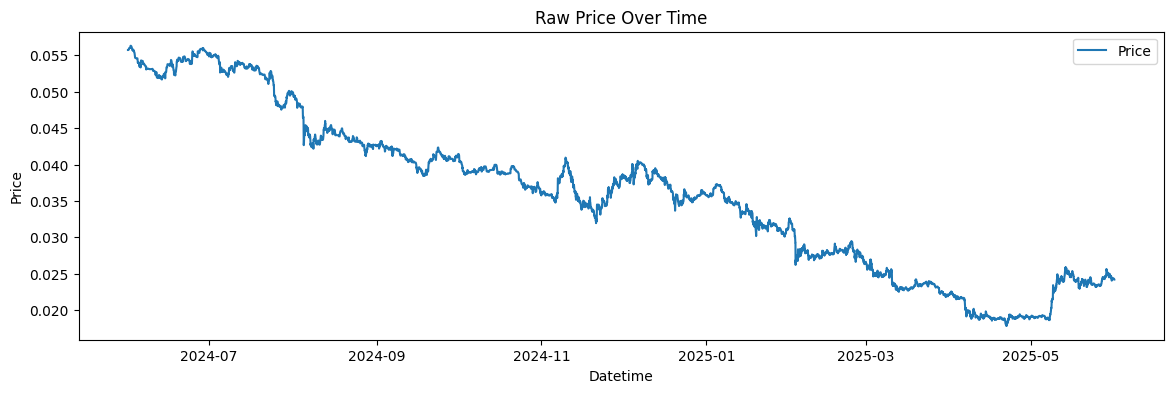

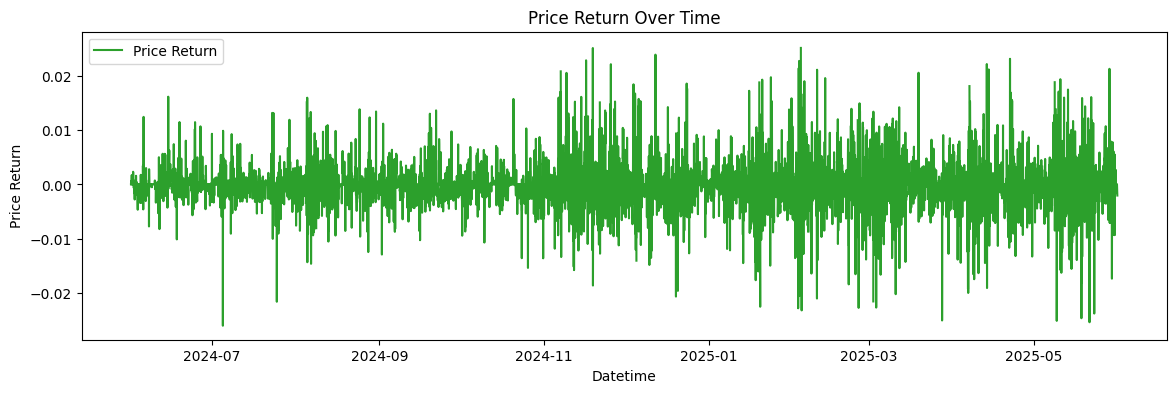

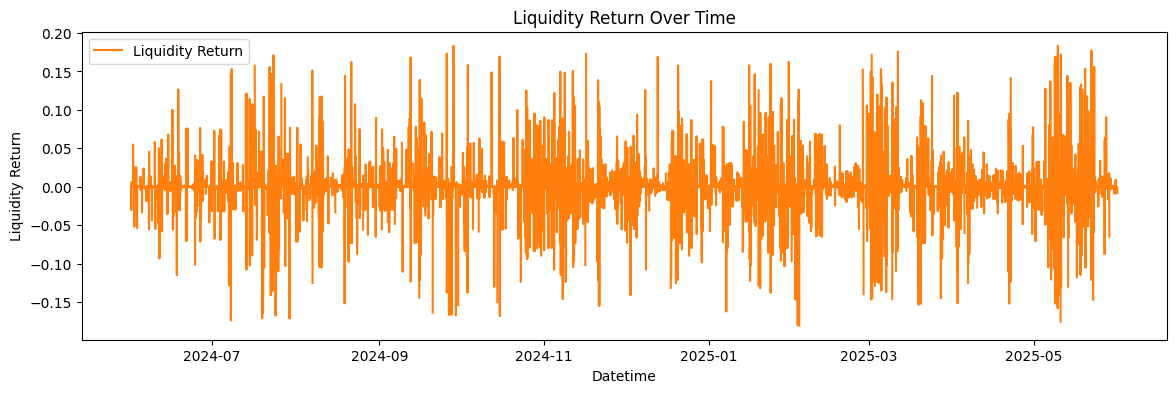

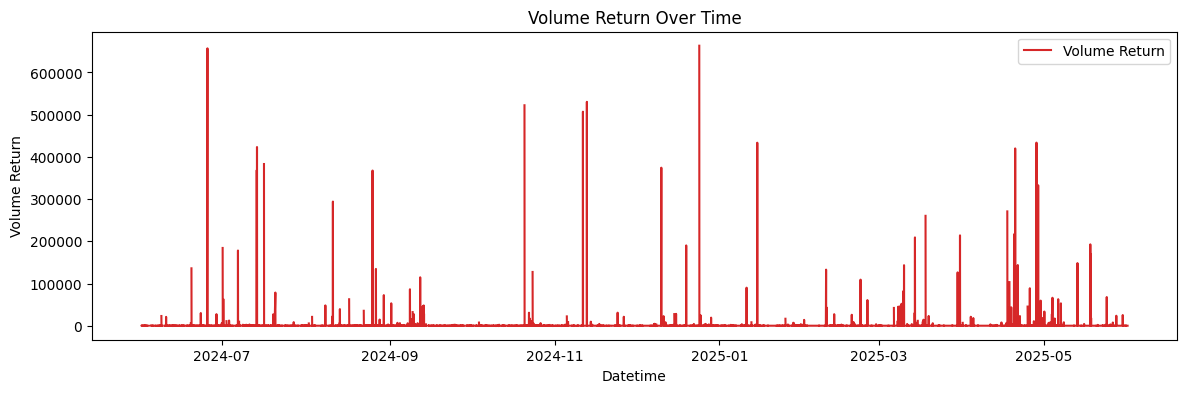

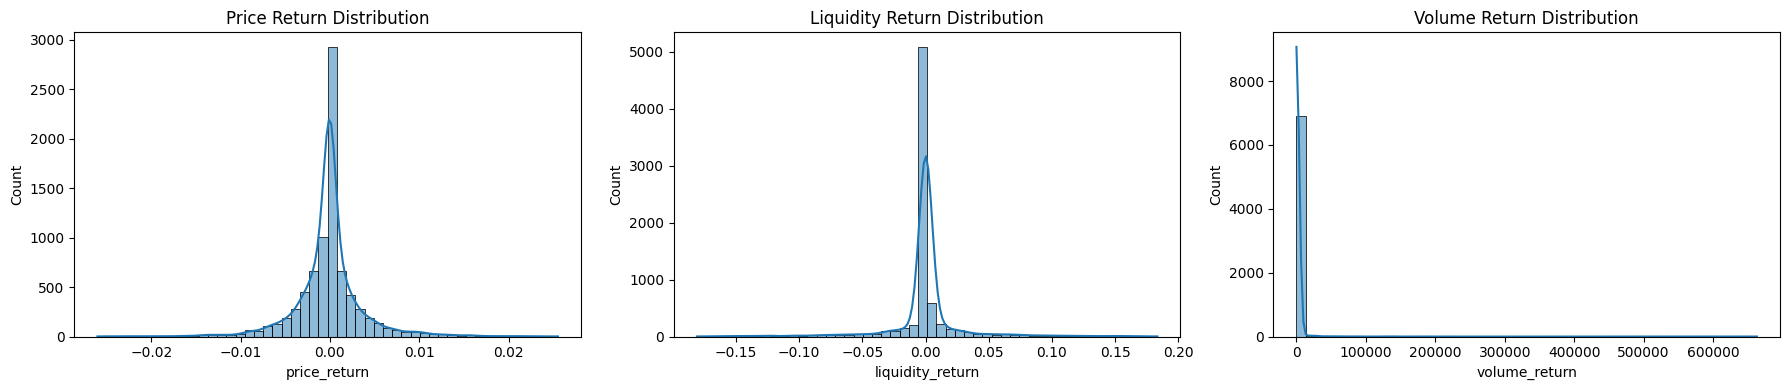

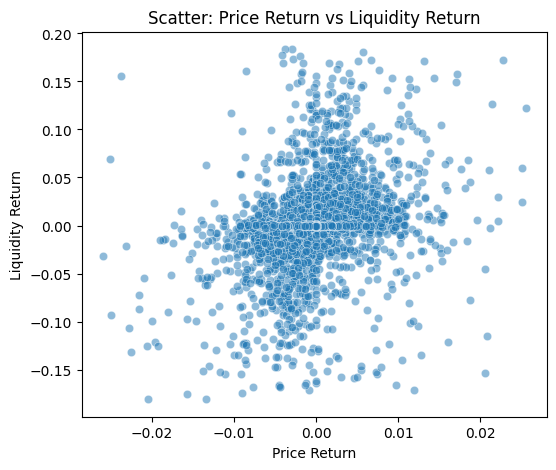

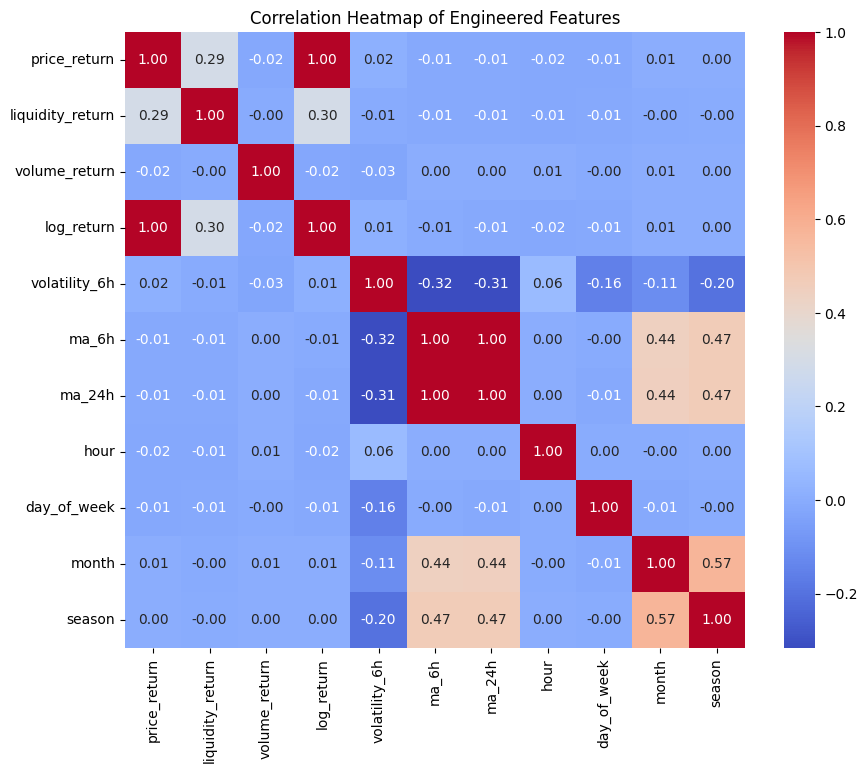

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot raw price over time
plt.figure(figsize=(14, 4))
plt.plot(test_df['datetime'], test_df['price'], label='Price', color='tab:blue')
plt.title('Raw Price Over Time')
plt.xlabel('Datetime')
plt.ylabel('Price')
plt.legend()
plt.show()

# Plot price return over time
plt.figure(figsize=(14, 4))
plt.plot(test_df['datetime'], test_df['price_return'], label='Price Return', color='tab:green')
plt.title('Price Return Over Time')
plt.xlabel('Datetime')
plt.ylabel('Price Return')
plt.legend()
plt.show()

# Plot liquidity return over time
plt.figure(figsize=(14, 4))
plt.plot(test_df['datetime'], test_df['liquidity_return'], label='Liquidity Return', color='tab:orange')
plt.title('Liquidity Return Over Time')
plt.xlabel('Datetime')
plt.ylabel('Liquidity Return')
plt.legend()
plt.show()

# Plot volume return over time
plt.figure(figsize=(14, 4))
plt.plot(test_df['datetime'], test_df['volume_return'], label='Volume Return', color='tab:red')
plt.title('Volume Return Over Time')
plt.xlabel('Datetime')
plt.ylabel('Volume Return')
plt.legend()
plt.show()

# Histograms of returns
fig, axs = plt.subplots(1, 3, figsize=(18, 4))
sns.histplot(test_df['price_return'].dropna(), bins=50, ax=axs[0], kde=True)
axs[0].set_title('Price Return Distribution')
sns.histplot(test_df['liquidity_return'].dropna(), bins=50, ax=axs[1], kde=True)
axs[1].set_title('Liquidity Return Distribution')
sns.histplot(test_df['volume_return'].dropna(), bins=50, ax=axs[2], kde=True)
axs[2].set_title('Volume Return Distribution')
plt.tight_layout()
plt.show()

# Scatter plot: price_return vs liquidity_return
plt.figure(figsize=(6, 5))
sns.scatterplot(x=test_df['price_return'], y=test_df['liquidity_return'], alpha=0.5)
plt.title('Scatter: Price Return vs Liquidity Return')
plt.xlabel('Price Return')
plt.ylabel('Liquidity Return')
plt.show()

# Correlation heatmap of engineered features
engineered_cols = [
    'price_return', 'liquidity_return', 'volume_return',
    'log_return', 'volatility_6h', 'ma_6h', 'ma_24h',
    'hour', 'day_of_week', 'month', 'season'
]
plt.figure(figsize=(10, 8))
sns.heatmap(test_df[engineered_cols].corr(), annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Correlation Heatmap of Engineered Features')
plt.show()

## Stationarity Check

To ensure robust modeling, we check the stationarity of the price, price returns, and log returns using the Augmented Dickey-Fuller (ADF) test. Stationary series are required for many time series models.

In [6]:
from statsmodels.tsa.stattools import adfuller

# Helper function for ADF test
def adf_test(series, name):
    clean_series = series.replace([np.inf, -np.inf], np.nan).dropna()
    if len(clean_series) < 10:
        print(f"Not enough valid data for {name} to run ADF test.")
        return
    result = adfuller(clean_series)
    print(f"ADF Statistic for {name}: {result[0]:.4f}")
    print(f"p-value: {result[1]:.4g}")
    for key, value in result[4].items():
        print(f"    Critical Value {key}: {value:.4f}")
    print("Stationary" if result[1] < 0.05 else "Not stationary", "\n")
print("--- Stationarity Check ---")
adf_test(test_df['price'], 'price')
adf_test(test_df['price_return'], 'price_return')
adf_test(test_df['log_return'], 'log_return')
adf_test(test_df['liquidity_return'], 'liquidity_return')
adf_test(test_df['volume_return'], 'volume_return')

--- Stationarity Check ---
ADF Statistic for price: -1.5963
p-value: 0.4854
    Critical Value 1%: -3.4312
    Critical Value 5%: -2.8619
    Critical Value 10%: -2.5670
Not stationary 

ADF Statistic for price_return: -14.5913
p-value: 4.31e-27
    Critical Value 1%: -3.4312
    Critical Value 5%: -2.8619
    Critical Value 10%: -2.5670
Stationary 

ADF Statistic for log_return: -14.6041
p-value: 4.121e-27
    Critical Value 1%: -3.4312
    Critical Value 5%: -2.8619
    Critical Value 10%: -2.5670
Stationary 

ADF Statistic for liquidity_return: -33.1625
p-value: 0
    Critical Value 1%: -3.4312
    Critical Value 5%: -2.8619
    Critical Value 10%: -2.5670
Stationary 

ADF Statistic for volume_return: -56.9170
p-value: 0
    Critical Value 1%: -3.4313
    Critical Value 5%: -2.8620
    Critical Value 10%: -2.5670
Stationary 



## Benchmark Model and Evaluation Functions

We start with a naive benchmark model that predicts the next value as the current value (a persistence or "random walk" model). We also define evaluation functions (e.g., MAE, RMSE, MAPE) to assess model performance. These functions can be reused for more sophisticated models later.

In [7]:
# Prepare training data: only use up to 80% chronologically from each pool
def get_chronological_split(df, split=0.8):
    df = df.sort_values('datetime').reset_index(drop=True)
    split_idx = int(len(df) * split)
    return df.iloc[:split_idx], df.iloc[split_idx:]

In [8]:
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt

def naive_predict(series):
    """Naive model: predicts next value as the current value (persistence)."""
    # Shift series by 1 to get prediction for t+1 at time t
    return series.shift(1)

def evaluate_predictions(y_true, y_pred):
    """Compute MAE, RMSE, and MAPE for predictions."""
    mask = ~np.isnan(y_true) & ~np.isnan(y_pred)
    y_true = y_true[mask]
    y_pred = y_pred[mask]
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100 if np.all(y_true != 0) else np.nan
    return {'MAE': mae, 'RMSE': rmse, 'MAPE': mape}

def plot_actual_vs_predicted(y_true, y_pred, title="Actual vs Predicted Liquidity Return"):
    plt.figure(figsize=(14, 5))
    plt.plot(y_true.index, y_true, label="Actual", color="tab:blue")
    plt.plot(y_true.index, y_pred, label="Predicted", color="tab:orange")
    plt.title(title)
    plt.xlabel("Index")
    plt.ylabel("Liquidity Return")
    plt.legend()
    plt.tight_layout()
    plt.show()

In [9]:
# Example: Benchmark for price prediction
_, test_df_test = get_chronological_split(test_df, split=0.8)
y_true = test_df_test['liquidity_return'].iloc[1:]  # true values from t=1
naive_pred = naive_predict(test_df_test['liquidity_return']).iloc[1:]  # predictions for t=1 onward
results = evaluate_predictions(y_true, naive_pred)
print("Naive benchmark results for liquidity_return:", results)

Naive benchmark results for liquidity_return: {'MAE': 0.021472455608107854, 'RMSE': np.float64(0.04636607572928178), 'MAPE': nan}


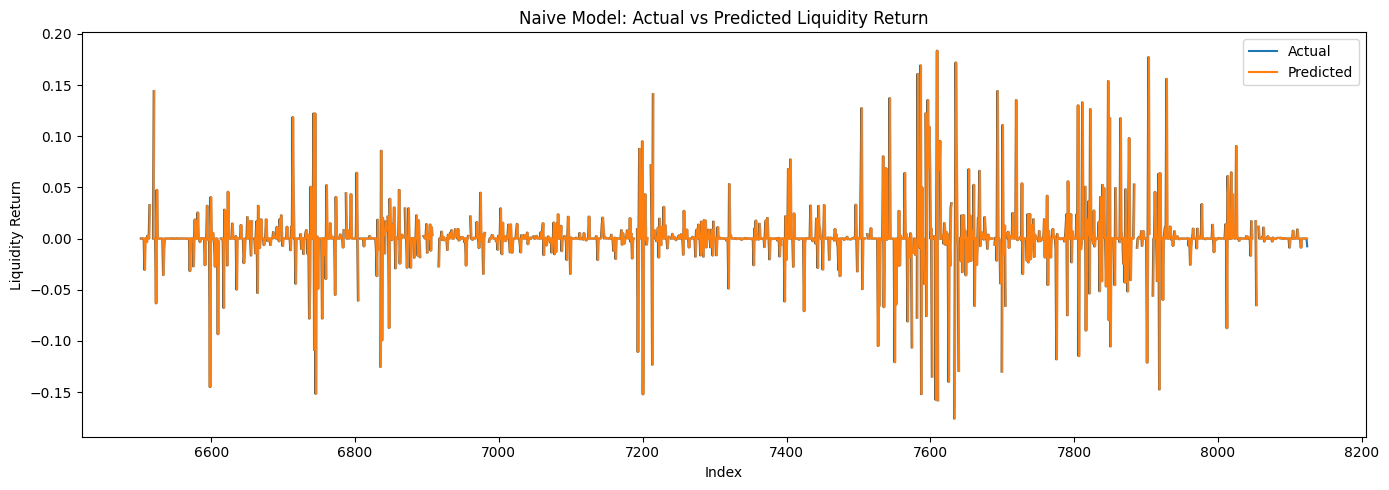

In [10]:
# Plot for Naive Benchmark Model
plot_actual_vs_predicted(y_true, naive_pred, title="Naive Model: Actual vs Predicted Liquidity Return")

## Simple Linear Regression: Predicting Liquidity Return from Lagged Price and Liqudity Returns

We now fit a linear regression model to predict the next-step liquidity return using past price and liqudity returns.

In [11]:
from sklearn.linear_model import SGDRegressor
from sklearn.preprocessing import StandardScaler

# Number of lags to include
n_lags = 3

# List of pool addresses to train on (already defined as train_pool_addresses)
features = [f'price_return_lag{lag}' for lag in range(1, n_lags + 1)] + \
           [f'liquidity_return_lag{lag}' for lag in range(1, n_lags + 1)]

# Incrementally train on each pool's data (first 80%)
scaler = StandardScaler()
sgd = SGDRegressor(max_iter=1000, tol=None, warm_start=True, random_state=42)
first_batch = True

# Incrementally train on each pool's data
for pool_df in train_dfs:
    pool_df = feature_engineering(pool_df)
    pool_df = add_lagged_features(pool_df, n_lags=n_lags)
    pool_df_train, _ = get_chronological_split(pool_df, split=0.8)
    X_pool = pool_df_train[features]
    y_pool = pool_df_train['liquidity_return_next']
    mask = X_pool.notnull().all(axis=1) & y_pool.notnull()
    X_pool = X_pool[mask]
    y_pool = y_pool[mask]
    if len(X_pool) == 0:
        continue
    if first_batch:
        scaler.fit(X_pool)
        X_pool_scaled = scaler.transform(X_pool)
        sgd.partial_fit(X_pool_scaled, y_pool)
        first_batch = False
    else:
        X_pool_scaled = scaler.transform(X_pool)
        sgd.partial_fit(X_pool_scaled, y_pool)

# Prepare test set: only use last 10% chronologically
test_df_fe = feature_engineering(test_df)
test_df_fe = add_lagged_features(test_df_fe, n_lags=n_lags)
_, test_df_test = get_chronological_split(test_df_fe, split=0.9)
X_test = test_df_test[features]
y_test = test_df_test['liquidity_return_next']
mask = X_test.notnull().all(axis=1) & y_test.notnull()
X_test = X_test[mask]
y_test = y_test[mask]
X_test_scaled = scaler.transform(X_test)

# Predict and evaluate
y_pred = sgd.predict(X_test_scaled)
results = evaluate_predictions(y_test, y_pred)
print("Incremental linear regression (SGDRegressor) results for liquidity_return_next:", results)

# Show coefficients for interpretability
coef_table = pd.DataFrame({'feature': features, 'coefficient': sgd.coef_})
print(coef_table)

Incremental linear regression (SGDRegressor) results for liquidity_return_next: {'MAE': 0.015335827140417807, 'RMSE': np.float64(0.034026710241968114), 'MAPE': nan}
                 feature  coefficient
0      price_return_lag1     0.000155
1      price_return_lag2     0.000372
2      price_return_lag3    -0.000522
3  liquidity_return_lag1    -0.003550
4  liquidity_return_lag2    -0.000658
5  liquidity_return_lag3    -0.002669


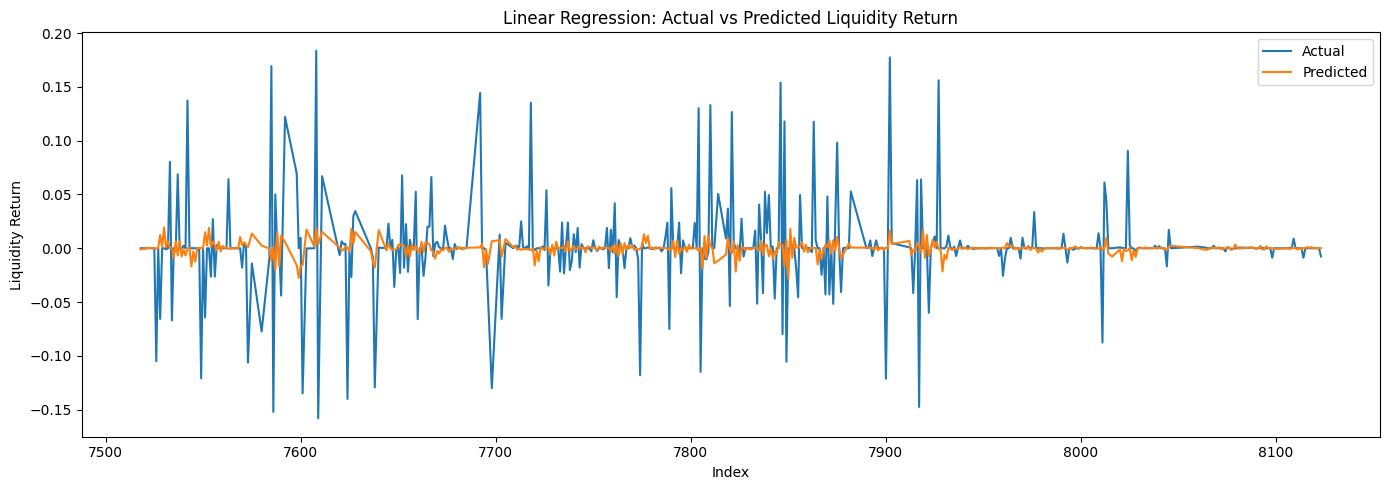

In [12]:
# Plot for Linear Regression Model
plot_actual_vs_predicted(y_test[-500:], y_pred[-500:], title="Linear Regression: Actual vs Predicted Liquidity Return")

## XGBoost Regression

In [13]:
import xgboost as xgb
import pandas as pd
import cupy as cp
from sklearn.model_selection import ParameterGrid

# --- Check GPU availability ---
def use_gpu():
    try:
        _ = cp.arange(1)  # Try a simple GPU allocation
        return True
    except cp.cuda.runtime.CUDARuntimeError:
        return False

gpu_available = use_gpu()
device_type = 'cuda' if gpu_available else 'cpu'
print(f"Using device: {device_type}")

# --- XGBoost Hyperparameter Tuning (including n_lags) ---
xgb_param_grid = {
    'n_lags': [3, 5, 10],
    'n_estimators': [10, 50, 200],
    'max_depth': [3, 5],
    'learning_rate': [0.01, 0.1],
}

best_score = float('inf')
best_params = None

for params in ParameterGrid(xgb_param_grid):
    n_lags = params['n_lags']
    lagged_features = [f'price_return_lag{lag}' for lag in range(1, n_lags + 1)] + \
                      [f'liquidity_return_lag{lag}' for lag in range(1, n_lags + 1)]
    engineered_features = ["volatility_6h", "ma_6h", "ma_24h", "hour", "day_of_week", "month", "season"]
    features = lagged_features + engineered_features

    # Prepare full training data
    X_train_all, y_train_all = [], []
    for pool_df in train_dfs:
        pool_df = feature_engineering(pool_df)
        pool_df = add_lagged_features(pool_df, n_lags=n_lags)
        pool_df_train, _ = get_chronological_split(pool_df, split=0.8)
        X_pool = pool_df_train[features]
        y_pool = pool_df_train['liquidity_return_next']
        mask = X_pool.notnull().all(axis=1) & y_pool.notnull()
        X_pool = X_pool[mask]
        y_pool = y_pool[mask]
        if len(X_pool) == 0:
            continue
        X_train_all.append(X_pool)
        y_train_all.append(y_pool)
    if not X_train_all:
        continue

    X_train_full = pd.concat(X_train_all, axis=0)
    y_train_full = pd.concat(y_train_all, axis=0)

    # Chronological split for validation
    split_idx = int(len(X_train_full) * 0.8)
    X_train, X_val = X_train_full.iloc[:split_idx], X_train_full.iloc[split_idx:]
    y_train, y_val = y_train_full.iloc[:split_idx], y_train_full.iloc[split_idx:]

    model = xgb.XGBRegressor(
        n_estimators=params['n_estimators'],
        max_depth=params['max_depth'],
        learning_rate=params['learning_rate'],
        random_state=42,
        n_jobs=-1,
        device=device_type
    )
    model.fit(X_train, y_train)

    if gpu_available:
        y_pred = model.predict(cp.array(X_val.values))
    else:
        y_pred = model.predict(X_val.values)

    score = evaluate_predictions(y_val, y_pred)['RMSE']
    print(f"Params: {params}, Val RMSE: {score:.5f}")
    if score < best_score:
        best_score = score
        best_params = params

print(f"\nBest XGBoost params: {best_params}, Best Val RMSE: {best_score:.5f}")

# --- Retrain best XGBoost model on all training data and evaluate on test set ---
n_lags = best_params['n_lags']
lagged_features = [f'price_return_lag{lag}' for lag in range(1, n_lags + 1)] + \
                  [f'liquidity_return_lag{lag}' for lag in range(1, n_lags + 1)]
features = lagged_features + engineered_features

X_train_all, y_train_all = [], []
for pool_df in train_dfs:
    pool_df = feature_engineering(pool_df)
    pool_df = add_lagged_features(pool_df, n_lags=n_lags)
    pool_df_train, _ = get_chronological_split(pool_df, split=0.8)
    X_pool = pool_df_train[features]
    y_pool = pool_df_train['liquidity_return_next']
    mask = X_pool.notnull().all(axis=1) & y_pool.notnull()
    X_pool = X_pool[mask]
    y_pool = y_pool[mask]
    if len(X_pool) == 0:
        continue
    X_train_all.append(X_pool)
    y_train_all.append(y_pool)

X_train_full = pd.concat(X_train_all, axis=0)
y_train_full = pd.concat(y_train_all, axis=0)

# Prepare test set
test_df_fe = feature_engineering(test_df)
test_df_fe = add_lagged_features(test_df_fe, n_lags=n_lags)
_, test_df_test = get_chronological_split(test_df_fe, split=0.8)
X_test = test_df_test[features]
y_test = test_df_test['liquidity_return_next']
mask = X_test.notnull().all(axis=1) & y_test.notnull()
X_test = X_test[mask]
y_test = y_test[mask]

final_xgb = xgb.XGBRegressor(
    n_estimators=best_params['n_estimators'],
    max_depth=best_params['max_depth'],
    learning_rate=best_params['learning_rate'],
    random_state=42,
    n_jobs=-1,
    device=device_type
)
final_xgb.fit(X_train_full, y_train_full)

if gpu_available:
    y_pred = final_xgb.predict(cp.array(X_test.values))
else:
    y_pred = final_xgb.predict(X_test.values)

results = evaluate_predictions(y_test, y_pred)
print("\nFinal XGBoost results (best params) for liquidity_return_next:")
for metric, value in results.items():
    print(f"{metric}: {value:.5f}")


Using device: cpu
Params: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 5, 'n_lags': 3}, Val RMSE: 0.03200
Params: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 5, 'n_lags': 5}, Val RMSE: 0.03195
Params: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 5, 'n_lags': 10}, Val RMSE: 0.03195
Params: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 5, 'n_lags': 15}, Val RMSE: 0.03123
Params: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 10, 'n_lags': 3}, Val RMSE: 0.03200
Params: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 10, 'n_lags': 5}, Val RMSE: 0.03194
Params: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 10, 'n_lags': 10}, Val RMSE: 0.03195
Params: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 10, 'n_lags': 15}, Val RMSE: 0.03122
Params: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 20, 'n_lags': 3}, Val RMSE: 0.03200
Params: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 20, 'n_lags': 5}, 

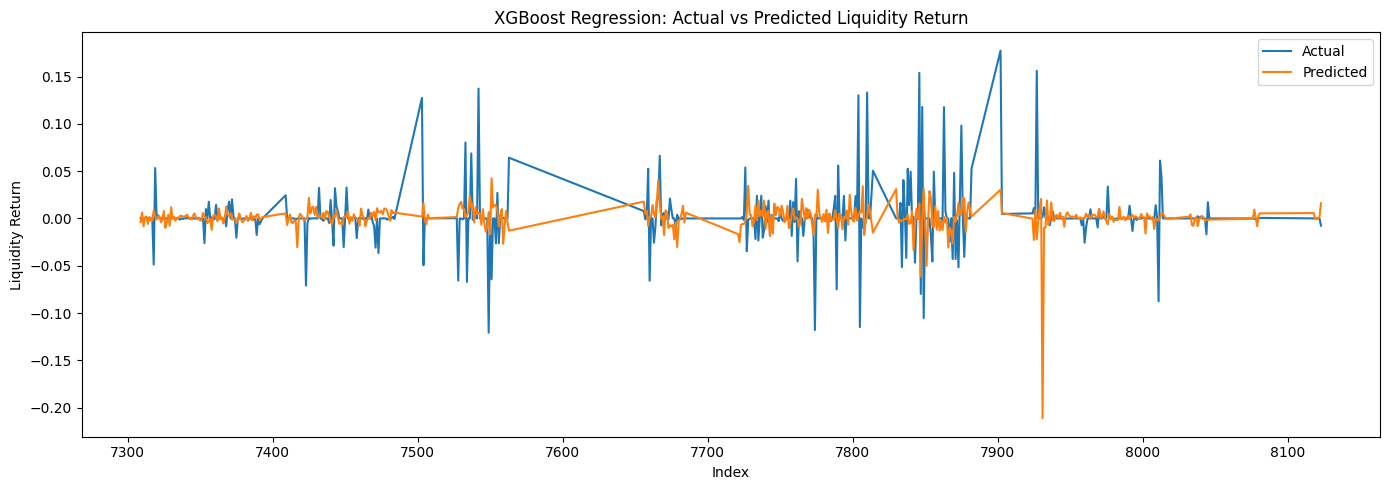

In [14]:
# Plot for Linear Regression Model
plot_actual_vs_predicted(y_test[-500:], y_pred[-500:], title="XGBoost Regression: Actual vs Predicted Liquidity Return")

## 1D CNN Regression with PyTorch: Predicting Liquidity Return

We now fit a simple 1D CNN regression model using PyTorch to predict the next-step liquidity return from lagged and engineered features. The CNN is trained incrementally on all pools, similar to the previous regressions.

In [ ]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import ParameterGrid
from torch.utils.data import Dataset, DataLoader

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# CNN-based Regressor
class CNNRegressor(nn.Module):
    def __init__(self, input_size, hidden_size, kernel_size=3):
        super().__init__()
        self.conv1 = nn.Conv1d(in_channels=input_size, out_channels=hidden_size, kernel_size=kernel_size, padding='same')
        self.relu = nn.ReLU()
        self.global_pool = nn.AdaptiveAvgPool1d(1)  # Global average pooling
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        # x: [batch_size, seq_len, input_size]
        x = x.permute(0, 2, 1)  # [batch_size, input_size, seq_len] for Conv1D
        x = self.conv1(x)
        x = self.relu(x)
        x = self.global_pool(x).squeeze(-1)  # [batch_size, hidden_size]
        return self.fc(x).squeeze()

# Same as before
class SequenceDataset(Dataset):
    def __init__(self, X, y, seq_len):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)
        self.seq_len = seq_len

    def __len__(self):
        return len(self.X) - self.seq_len

    def __getitem__(self, idx):
        return (
            self.X[idx:idx + self.seq_len],
            self.y[idx + self.seq_len]
        )

def prepare_data(n_lags, features):
    X_train_all, y_train_all = [], []
    for pool_df in train_dfs:
        pool_df = feature_engineering(pool_df)
        pool_df = add_lagged_features(pool_df, n_lags=n_lags)
        pool_df_train, _ = get_chronological_split(pool_df, split=0.8)
        pool_df_train = pool_df_train.dropna(subset=features + ['liquidity_return_next'])

        if len(pool_df_train) <= n_lags:
            continue

        X_train_all.append(pool_df_train[features])
        y_train_all.append(pool_df_train['liquidity_return_next'])

    if not X_train_all:
        return None, None, None, None, None

    X_full = pd.concat(X_train_all).to_numpy()
    y_full = pd.concat(y_train_all).to_numpy()

    split_idx = int(len(X_full) * 0.8)
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_full[:split_idx])
    X_val = scaler.transform(X_full[split_idx:])
    y_train = y_full[:split_idx]
    y_val = y_full[split_idx:]
    return X_train, X_val, y_train, y_val, scaler

# Grid search
best_score = float('inf')
best_params = None

print("Finished preparing data. Starting grid search...")

for params in ParameterGrid({
    'n_lags': [3, 5, 10],
    'hidden_size': [8, 16, 32],
    'batch_size': [64],
}):
    print(f"\nStarting new iteration with params: {params}")
    n_lags = params['n_lags']
    lagged_features = [f'{kind}_return_lag{lag}' for kind in ['price', 'liquidity'] for lag in range(1, n_lags + 1)]
    features = lagged_features + engineered_features

    X_train, X_val, y_train, y_val, scaler = prepare_data(n_lags, features)
    if X_train is None:
        continue

    train_dataset = SequenceDataset(X_train, y_train, n_lags)
    val_dataset = SequenceDataset(X_val, y_val, n_lags)
    train_loader = DataLoader(train_dataset, batch_size=params['batch_size'], shuffle=False, pin_memory=True, num_workers=2)
    val_loader = DataLoader(val_dataset, batch_size=params['batch_size'], shuffle=False, pin_memory=True, num_workers=2)

    model = CNNRegressor(input_size=X_train.shape[1], hidden_size=params['hidden_size']).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.MSELoss()

    for epoch in range(20):
        model.train()
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            loss = criterion(model(X_batch), y_batch)
            loss.backward()
            optimizer.step()

    model.eval()
    preds, trues = [], []
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch = X_batch.to(device)
            output = model(X_batch).cpu().numpy()
            preds.append(output)
            trues.append(y_batch.numpy())

    y_pred = np.concatenate(preds)
    y_true = np.concatenate(trues)
    score = evaluate_predictions(y_true, y_pred)['RMSE']
    print(f"Val RMSE: {score:.5f}")

    if score < best_score:
        best_score = score
        best_params = params
        best_pred = y_pred

print(f"\nBest CNN params: {best_params}, Best Val RMSE: {best_score:.5f}")


Using device: cpu
Finished preparing data. Starting grid search...

Starting new iteration with params: {'batch_size': 64, 'hidden_size': 8, 'n_lags': 3}
Val RMSE: 0.03208

Starting new iteration with params: {'batch_size': 64, 'hidden_size': 8, 'n_lags': 5}
Val RMSE: 0.03209

Starting new iteration with params: {'batch_size': 64, 'hidden_size': 8, 'n_lags': 10}
Val RMSE: 0.03218

Starting new iteration with params: {'batch_size': 64, 'hidden_size': 16, 'n_lags': 3}


In [ ]:
# Plot for RNN Model
plot_actual_vs_predicted(pd.Series(y_true[:500]), pd.Series(y_pred[:500]), title="1D CNN: Actual vs Predicted Liquidity Return")

## RNN Regression with PyTorch: Predicting Liquidity Return

We now fit a simple RNN (LSTM) regression model using PyTorch to predict the next-step liquidity return from lagged and engineered features. The RNN is trained incrementally on all pools, similar to the previous regressions.

In [ ]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import ParameterGrid
from torch.utils.data import Dataset, DataLoader

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

class LSTMRegressor(nn.Module):
    def __init__(self, input_size, hidden_size):
        super().__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        out, _ = self.lstm(x)
        return self.fc(out[:, -1, :]).squeeze()

class SequenceDataset(Dataset):
    def __init__(self, X, y, seq_len):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)
        self.seq_len = seq_len

    def __len__(self):
        return len(self.X) - self.seq_len

    def __getitem__(self, idx):
        return (
            self.X[idx:idx + self.seq_len],
            self.y[idx + self.seq_len]
        )

def prepare_data(n_lags, features):
    X_train_all, y_train_all = [], []
    for pool_df in train_dfs:
        pool_df = feature_engineering(pool_df)
        pool_df = add_lagged_features(pool_df, n_lags=n_lags)
        pool_df_train, _ = get_chronological_split(pool_df, split=0.8)
        pool_df_train = pool_df_train.dropna(subset=features + ['liquidity_return_next'])

        if len(pool_df_train) <= n_lags:
            continue

        X_train_all.append(pool_df_train[features])
        y_train_all.append(pool_df_train['liquidity_return_next'])

    if not X_train_all:
        return None, None, None, None, None

    X_full = pd.concat(X_train_all).to_numpy()
    y_full = pd.concat(y_train_all).to_numpy()

    split_idx = int(len(X_full) * 0.8)
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_full[:split_idx])
    X_val = scaler.transform(X_full[split_idx:])
    y_train = y_full[:split_idx]
    y_val = y_full[split_idx:]
    return X_train, X_val, y_train, y_val, scaler

print("Finished preparing data. Starting grid search...")

# Grid search
best_score = float('inf')
best_params = None

for params in ParameterGrid({
    'n_lags': [3, 5, 10],
    'hidden_size': [8, 16, 32],
    'batch_size': [64],
}):
    print("Starting new iteration...")
    print(f"Params: {params}")
    n_lags = params['n_lags']
    lagged_features = [f'{kind}_return_lag{lag}' for kind in ['price', 'liquidity'] for lag in range(1, n_lags + 1)]
    features = lagged_features + engineered_features

    X_train, X_val, y_train, y_val, scaler = prepare_data(n_lags, features)
    if X_train is None:
        continue

    train_dataset = SequenceDataset(X_train, y_train, n_lags)
    val_dataset = SequenceDataset(X_val, y_val, n_lags)
    train_loader = DataLoader(train_dataset, batch_size=params['batch_size'], shuffle=False, pin_memory=True, num_workers=2)
    val_loader = DataLoader(val_dataset, batch_size=params['batch_size'], shuffle=False, pin_memory=True, num_workers=2)

    model = LSTMRegressor(input_size=X_train.shape[1], hidden_size=params['hidden_size']).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.MSELoss()

    for epoch in range(20):
        model.train()
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            loss = criterion(model(X_batch), y_batch)
            loss.backward()
            optimizer.step()

    model.eval()
    preds, trues = [], []
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch = X_batch.to(device)
            output = model(X_batch).cpu().numpy()
            preds.append(output)
            trues.append(y_batch.numpy())

    y_pred = np.concatenate(preds)
    y_true = np.concatenate(trues)
    score = evaluate_predictions(y_true, y_pred)['RMSE']
    print(f"Val RMSE: {score:.5f}")

    if score < best_score:
        best_score = score
        best_params = params
        best_pred = y_pred

print(f"Best LSTM params: {best_params}, Best Val RMSE: {best_score:.5f}")


In [ ]:
# Plot for RNN Model
plot_actual_vs_predicted(pd.Series(y_true[:500]), pd.Series(y_pred[:500]), title="RNN (LSTM): Actual vs Predicted Liquidity Return")